# TS-DAR Tutorial for Alanine Dipeptide
**Reference**: Liu, B., Boysen, J.G., Unarta, I.C. et al. Exploring transition states of protein conformational changes via out-of-distribution detection in the hyperspherical latent space. Nat Commun 16, 349 (2025). https://doi.org/10.1038/s41467-024-55228-4

---
## TS-DAR Framework: An Overview

In this notebook, we introduce **Transition State identification via Dispersion and vAriational principle Regularized neural networks (TS-DAR)**, a computational framework that utilizes out-of-distribution (OOD) detection to accurately and simultaneously identify transition states involved in specific biomolecular conformational changes. TS-DAR leverages a deep learning model to map protein conformations from molecular dynamics (MD) simulations into a hyperspherical latent space. This low-dimensional representation preserves the essential kinetic information while still capturing the protein's dynamic behavior. To distinguish metastable states from transition states, TS-DAR employs a VAMP-2 loss and dispersion loss function:

1. **VAMP-2 Loss:** Encourages the latent representation to capture the slow dynamics of the system by maximizing correlations between time-lagged data.
2. **Dispersion Loss:** Ensures that the latent space does not collapse by promoting a well-dispersed representation of the macrostates.

---

### VAMP-2 Loss

The VAMP-2 loss is derived from the Variational Approach for Markov Processes, which aims to extract the slow collective variables from the data. Given an MD trajectory of length $T$, a batch of transition pairs $\{(x_t, x_{t+\tau})\}_{t=1}^b$ with lag time, $\tau$, is sampled. This produces two batches of data: $\mathbf{B} = [x_1, x_2, \dots, x_b]^T$ and $\mathbf{\hat{B}} = [x_{1+\tau}, x_{2+\tau}, \dots, x_{b+\tau}]^T$, which are fed into two parallel network lobes with shared parameters. Each lobe outputs SoftMax-transformed basis functions ($\chi$) applied to the input features, yielding: $\mathbf{X} = [\chi(x_1), \dots, \chi(x_b)]^T$ and $\mathbf{Y} = [\chi(x_{1+\tau}), \dots, \chi(x_{b+\tau})]^T$. The remove-mean time-instantaneous ($\bar{\mathbf{C}}_{00}$ and $\bar{\mathbf{C}}_{11}$) and time-lagged ($\bar{\mathbf{C}}_{01}$) correlation matrices can then be calculated as follows:

$$
\bar{\mathbf{C}}_{00} = \frac{1}{T - \tau} \mathbf{X}^T \mathbf{X} - \boldsymbol{\pi}_0 \boldsymbol{\pi}_0^T
$$

$$
\bar{\mathbf{C}}_{11} = \frac{1}{T - \tau} \mathbf{Y}^T \mathbf{Y} - \boldsymbol{\pi}_1 \boldsymbol{\pi}_1^T
$$

$$
\bar{\mathbf{C}}_{01} = \frac{1}{T - \tau} \mathbf{X}^T \mathbf{Y} - \boldsymbol{\pi}_0 \boldsymbol{\pi}_1^T
$$

where $\boldsymbol{\pi}_0$ and $\boldsymbol{\pi}_1$ are mean vectors of $\mathbf{X}$ and $\mathbf{Y}$, respectively, given by: $\boldsymbol{\pi}_0$ = $\frac{1}{T - \tau} \mathbf{X}^T \mathbf{1}$ and $\boldsymbol{\pi}_1$ = $\frac{1}{T - \tau} \mathbf{Y}^T \mathbf{1}$. These correlation matrices are then used to calculate the VAMP-2 loss, which is defined as:

$$
\mathcal{L}_{\text{vamp2}} = - \left\| \bar{\mathbf{C}}_{00}^{-\frac{1}{2}} \bar{\mathbf{C}}_{01} \bar{\mathbf{C}}_{11}^{-\frac{1}{2}} \right\|_{\mathcal{F}}^2 - 1
$$

Minimizing this loss drives the model to learn latent features that capture the slow dynamical modes in the molecular system.

---

### Dispersion Loss

While the VAMP-2 loss focuses on capturing the slow dynamics, it can sometimes result in a latent space where the features collapse to similar values. To counteract this, TS-DAR incorporates a **dispersion loss** that encourages diversity in the latent space. One way to formulate the dispersion loss is by ensuring that the pairwise distances between latent representations are close to a target mean distance. The dispersion loss is defined as:

$$\mathcal{L}_{dis} = \frac{1}{C} \sum_{i=1}^{C} \log \frac{1}{C-1} \sum_{j=1}^{C} \mathbf{1}_{\{j \neq i\}} e^{\frac{\mu_i^T \mu_j}{\sigma}}$$
where:
- $C$ corresponds to the number of states.
- $\mu_i$ is a unit vector representing the mean direction of all conformations (i.e., the state center) in state $i$.
- $\sigma$ is a scaling hyperparameter, which is specifically defined as 0.1.
- $\mathbf{1}_{\{j \neq i\}}$ is an indicator function that equals 1 when $j \neq i$ (i.e., excluding self-similarity) and 0 when $j = i$.

This loss penalizes deviations from the target dispersion, ensuring that the latent features remain well-separated and informative.

---

### Combined Loss Function

The overall training objective of the TS-DAR framework is a weighted combination of the VAMP-2 loss and the dispersion loss:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{VAMP-2}} + β\mathcal{L}_{\text{disp}}
$$

Here, (`β`) is a hyperparameter that balances the contribution of the dispersion term relative to the VAMP-2 loss.

---

### Summary

The TS-DAR framework leverages: (1) **VAMP-2 Loss** to extract the slow, metastable dynamics inherent in molecular systems, and (2) **Dispersion Loss** to maintain a well-structured, diverse latent space. This approach contains an end-to-end pipeline that enhances the detection of transition states, providing deeper insights into molecular conformational changes. In the sections that follow, we will demonstrate the implementation of these loss functions and apply the TS-DAR framework to analyze alanine dipeptide MD data.

---

## Before starting, make sure you have done the following:

#### 1. Download and install Anaconda:
wget https://repo.anaconda.com/archive/Anaconda3-2024.06-1-Linux-x86_64.sh <br>
./Anaconda3-2024.06-1-Linux-x86_64.sh
#### 2. Create a new conda environment and install the ts-dar source code locally:
conda create -n ts-dar python=3.9 <br>
conda activate ts-dar <br>
#### 3. Install dependencies
!pip install matplotlib numpy==1.26.1 scipy==1.11.4 torch==1.13.1 tqdm==4.66.1
#### 4. Clone the repository
!git clone https://github.com/xuhuihuang/ts-dar.git
#### 5. Install the package
!python -m pip install ./ts-dar

In [154]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from tsdar.utils import set_random_seed
from tsdar.loss import Prototypes
from tsdar.model import TSDAR, TSDARLayer, TSDAREstimator
from tsdar.dataprocessing import Preprocessing

In [156]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('cuda is available')
else:
    device = torch.device('cpu')
    print('cpu')

cpu


## Contour Plot of 2D Probability Densities:
This notebook implements a `ContourPlot2D` class for visualizing the free energy landscape using the **bivariate kernel density estimation (KDE)**.

### Features:
- **KDE Estimation**: Uses `scipy.stats.gaussian_kde` to compute probability densities.
- **Thermodynamic Transformation**: Converts KDE values using a logarithmic transformation.

In [158]:
class ContourPlot2D:

    def __init__(self, bw_method='scotts', num_grids=120, cut=3, clip=None,
                 temperature=310., shade=True, alpha=1, vmin=0, vmax=7, n_levels=15):

        self._bw_method = bw_method
        self._num_grids = num_grids
        self._cut = cut
        if clip is None:
            self._clip = [(-np.inf, np.inf), (-np.inf, np.inf)]
        self._temperature = temperature
        self._shade = shade
        self._alpha = alpha
        self._vmin = vmin
        self._vmax = vmax
        self._n_levels = n_levels

    def _kde_support(self, data, bw, num_grids, cut, clip):

        support_min = max(data.min() - bw * cut, clip[0])
        support_max = min(data.max() + bw * cut, clip[1])

        return np.linspace(support_min, support_max, num_grids)

    def _scipy_bivariate_kde(self, data, bw_method, num_grids, cut, clip):

        from scipy import stats
        kde = stats.gaussian_kde(data.T)
        std = data.std(axis=0, ddof=1)

        from six import string_types
        if isinstance(bw_method, string_types):
            bw_x = getattr(kde, "%s_factor" % bw_method)() * std[0]
            bw_y = getattr(kde, "%s_factor" % bw_method)() * std[1]
        else:
            raise ValueError('Please input the string of a valid bandwidth method.')

        x_support = self._kde_support(data[:, 0], bw_x, num_grids, cut, clip[0])
        y_support = self._kde_support(data[:, 1], bw_y, num_grids, cut, clip[1])

        xx, yy = np.meshgrid(x_support, y_support)
        z = kde([xx.ravel(), yy.ravel()]).reshape(xx.shape)

        return xx, yy, z

    def _thermo_transform(self, z, temperature):

        import scipy
        from scipy.constants import Avogadro, Boltzmann, calorie_th
        THERMO_CONSTANT = 10**-3 * Boltzmann * Avogadro / calorie_th

        #return - THERMO_CONSTANT * temperature * np.log(z)
        return - np.log(z)

    def plot(self, data, ax=None, cbar=True, cbar_kwargs={},
            xlabel=None, ylabel=None, labelsize=10):

        from matplotlib import pyplot as plt

        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = None

        X, Y, Z = self._scipy_bivariate_kde(data, self._bw_method, self._num_grids, self._cut, self._clip)
        Z = self._thermo_transform(Z, self._temperature)

        if self._vmin is None:
            self._vmin = -1E-12
        if self._vmax is None:
            self._vmax = np.percentile(Z, 50)

        if self._shade:
            cf = ax.contourf(X, Y, Z - Z.min(), levels=np.linspace(self._vmin, self._vmax, self._n_levels),
                             alpha=self._alpha, zorder=1, vmin=self._vmin, vmax=self._vmax, cmap='rainbow')

        cs = ax.contour(X, Y, Z - Z.min(),
                        #cmap=plt.get_cmap('bone_r'),
                        colors='black',
                        linewidths=1,
                        levels=np.linspace(self._vmin, self._vmax, self._n_levels), alpha=0.2,
                        zorder=1, vmin=self._vmin, vmax=self._vmax)

        if cbar:
            if self._shade:
                cbar = plt.colorbar(cf, **cbar_kwargs)
            else:
                cbar = plt.colorbar(cs, **cbar_kwargs)

            cbar.ax.tick_params(labelsize=15,length=5,width=1.5)
            #cbar.set_label('Free energy (kcal/mol)', fontsize=labelsize)

        #ax.grid(zorder=0)

        if xlabel:
            ax.set_xlabel(xlabel, size=labelsize)
        if ylabel:
            ax.set_ylabel(ylabel, size=labelsize)

        return ax,X,Y,Z - Z.min()

## Download and Load Alanine Dipeptide Simulation Data:
This section loads molecular dynamics (MD) simulation data for alanine dipeptide. We have:
- **Atomic coordinates (`xyz_traj`)**: 3D positions of atoms from the simulation.
- **Dihedral angles (`dihedral_traj`)**: Backbone torsion angles (ϕ, ψ) that define molecular conformation.

Each dataset contains **three independent trajectories**.

Please download the dataset from the link below, and place it under the base directory, unzip the file:

https://zenodo.org/records/16922765/files/Alanine_dipeptide.zip?download=1

Change the directrory to "./Alanine_dipeptide/".



In [159]:
# Initialize lists to store trajectory data
data = []
dihedral = []

# Define base directory path (modify as needed)
base_dir = './Alanine_dipeptide_data/'

# Load 3D atomic coordinates (trajectories)
for i in range(3):
    data_file_path = f'{base_dir}xyz_traj{i}.npy'  # Construct file path
    data.append(np.load(data_file_path))  # Load and append trajectory

# Load dihedral angles (Backbone torsion angles)
for i in range(3):
    d_file_path = f'{base_dir}dihedral_traj{i}.npy'  # Construct file path
    dihedral.append(np.load(d_file_path))  # Load and append trajectory

# Print dataset shapes to confirm loading
print(f"Loaded {len(data)} XYZ trajectories with shapes: {[d.shape for d in data]}")
print(f"Loaded {len(dihedral)} dihedral trajectories with shapes: {[d.shape for d in dihedral]}")

Loaded 3 XYZ trajectories with shapes: [(250000, 30), (250000, 30), (250000, 30)]
Loaded 3 dihedral trajectories with shapes: [(250000, 2), (250000, 2), (250000, 2)]


## Data Interpretation:
- **XYZ Trajectories**:  
  - **Shape**: `(250000, 30)`  
  - **Meaning**: 250K simulation frames, storing the **xyz positions of 10 atoms**.
- **Dihedral Trajectories**:  
  - **Shape**: `(250000, 2)`  
  - **Meaning**: 250K frames, each containing **two backbone torsion angles (ϕ, ψ)**.  
    
## Next Steps:
### Projecting the Free Energy Landscape:
We will now **compute and visualize the free energy landscape** of alanine dipeptide by projecting it onto the two backbone torsion angles, **ϕ (phi) and ψ (psi)**.

### Key Features:
- **Contour Plot**: Uses kernel density estimation to compute free energy.
- **Color Mapping**: Indicates stable and unstable molecular conformations.
- **Axes**:  
  - **X-axis (ϕ angle)** → Ranges from `-180°` to `180°`  
  - **Y-axis (ψ angle)** → Ranges from `-180°` to `180°`  

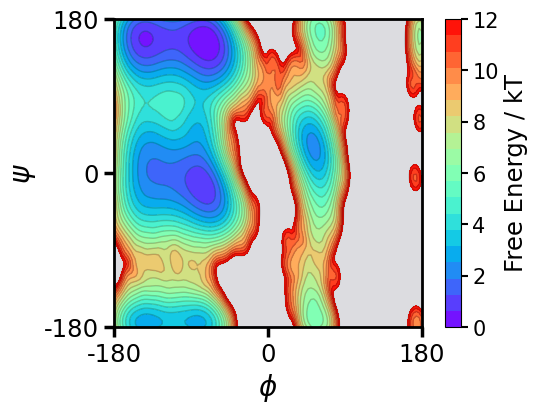

In [160]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Customize axis borders (thicker for better visibility)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

# Set aspect ratio to 1 (square plot)
ax.set_aspect(1)

# Initialize the ContourPlot2D class and plot free energy landscape
c = ContourPlot2D(shade=True, n_levels=20, vmax=12)
ax, X, Y, Z = c.plot(data=np.concatenate(dihedral), ax=ax, cbar=True)

# Set axis limits to cover the full range of torsion angles (-π to π)
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)

# Convert tick labels from radians to degrees for better readability
ax.set_xticks([-np.pi, 0, np.pi], labels=[-180, 0, 180])
ax.set_yticks([-np.pi, 0, np.pi], labels=[-180, 0, 180])

# Set a background color
r, g, b = 0.1, 0.1, 0.2  # Dark blue shade
ax.patch.set_facecolor((r, g, b, 0.15))  # Semi-transparent background

# Customize tick labels: increase font size and adjust tick properties
ax.tick_params(axis="both", labelsize=17.5, direction='out', length=7.5, width=2.5)

# Set axis labels with phi (ϕ) and psi (ψ) symbols
ax.set_xlabel(r'$\phi$', fontsize=20)
ax.set_ylabel(r'$\psi$', fontsize=20)

cbar_ax = fig.axes[-1]
cbar_ax.set_ylabel('Free Energy / kT', fontsize=17.5)
cbar_ax.set_yticks([0, 2, 4, 6, 8, 10, 12])  # Adjust the list to your desired ticks

## Preprocessing Molecular Dynamics Data:
Preprocess the original trajectories to create datasets for training.  

In [161]:
pre = Preprocessing(dtype=np.float32)
dataset = pre.create_dataset(lag_time=1,data=data) #The lag_time used to create the dataset consisting of time-instant and time-lagged data

## Training the TS-DAR Model:
We now train a TS-DAR Model to learn a **latent space representation of the protein structures**. This consists of **(a) feature extraction**: protein structures are transformed into a suitable representation (e.g., coordinates, distances, or angles between atoms); **(b) encoder training**: The encoder learns to compress the input conformations (high-dimensional protein structures) into a lower-dimensional latent space.

### Key Steps:
1. **Data Splitting**: 90% training data & 10% validation data (for model evaluation)
2. **Batch Loading**:  
   - Training batch size = `1000` (shuffled)
   - Validation batch = `entire validation set` (not shuffled)
3. **TS-DAR Model Setup**:  
   - **Latent space**: (`d-1`)-dimensional hypersphere
   - **n_states**: number of metastable states
   - **Learning rate**: `1e-3`  
   - **Weight of dispersion loss (`β`)**: `0.01` (has been optimized - this can stay at 0.01 for most systems). The determination of the magnitude of β is guided by the following two criteria: (1) The dispersion loss can converge to the minimum boundary; (2) There is no significant deviation in VAMP-2 loss before and after integrating the dispersion loss optimization.
4. **Training the Model**: Pretrain for 10 epochs, then train for another 10 epochs

In [162]:
# Ensure reproducibility by setting a fixed random seed
set_random_seed(33)

# Split dataset: 90% training, 10% validation
val = int(len(dataset)*0.10)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset)-val, val]) # randomly split the data

loader_train = DataLoader(train_data, batch_size=1000, shuffle=True) # load data in batches and shuffle data
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

# Initialize the TS-DAR model with specific network architecture
lobe = TSDARLayer([30,30,30,30,10,2],n_states=2)

# Move model to appropriate device (CPU/GPU)
lobe = lobe.to(device=device)

# Initialize TS-DAR model for training
tsdar = TSDAR(lobe = lobe, learning_rate = 1e-3, device = device, mode = 'regularize', beta=0.01, feat_dim=2, n_states=2, pretrain=10)
tsdar_model = tsdar.fit(loader_train, n_epochs=20, validation_loader=loader_val).fetch_model()

## TS-DAR Model Validation Curve:
To evaluate the TS-DAR model, we plot the **VAMP-2 loss** over training epochs. You should train the model until this plot converges. During training, the model adjusts its parameters to minizmize the loss function. Convergence means that the model's loss function is optimized, indicating that it has effectively learned patterns from the data. If stopped before convergence, the model might fail to learn the meaningful patterns.

**Training too little** → Model is underfit, leading to high error on both training & validation sets. \
**Training too much** → Model overfits, meaning it memorizes the training data but performs poorly on new data.

### What is VAMP-2 Loss?  
- **VAMP-2 (Variational Approach for Markov Processes)** measures how well the model captures slow dynamical processes.

$$ \mathcal{L}_{\text{vamp2}} = - \left\| \bar{\mathbf{C}}_{00}^{-\frac{1}{2}} \bar{\mathbf{C}}_{01} \bar{\mathbf{C}}_{11}^{-\frac{1}{2}} \right\|_{\mathcal{F}}^2 - 1 \tag{2} $$
### Interpretation:
- **Higher VAMP-2 score** (i.e., **lower loss**) → better approximation of **kinetic variance**, meaning:
  - Improved separation of **metastable states**
  - Latent space captures **meaningful dynamical structure**
- **Plateauing loss** → indicates **training convergence**

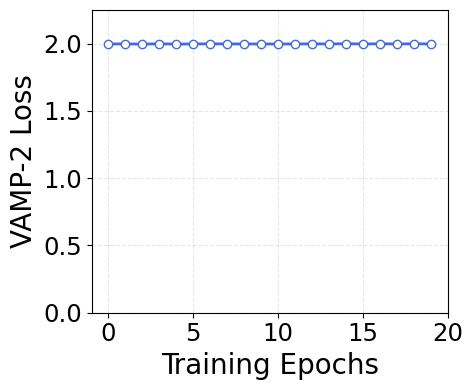

In [163]:
import matplotlib.pyplot as plt

# Create a figure with a specific size
fig = plt.figure(figsize=(6, 4))

# Define custom colors for the line and markers
line_color = 'royalblue'
marker_face = 'white'
marker_edge = 'royalblue'

# Plot with custom colors, line width, and markers
plt.plot(tsdar.validation_vamp, color=line_color, linewidth=2, marker='o',
         markersize=6, markerfacecolor=marker_face, markeredgecolor=marker_edge)

# Set the axis labels
plt.xlabel('Training Epochs', fontsize=20)
plt.ylabel('VAMP-2 Loss', fontsize=20)
plt.ylim(0, 2.25)
plt.yticks(np.arange(0, 2.1, 0.5))
plt.xticks(np.arange(0, 25, 5))

# Customize tick parameters for readability
plt.xticks(fontsize=17.5)
plt.yticks(fontsize=17.5)
plt.gca().set_box_aspect(0.85)

# Add a dashed grid to improve the readability of the plot
plt.grid(alpha=0.3, linestyle='--')

# Adjust the layout to ensure everything fits well
plt.tight_layout()

# Display the plot
plt.show()

## What is Dispersion Loss?

While the VAMP-2 loss enhances intrastate compactness, it can result in a latent space where different metastable states are unevenly distributed. To address this, TS-DAR incorporates a dispersion loss that regularizes the hyperspherical latent space, ensuring the metastable state centers (or free energy minima) are uniformly distributed across the hypersphere. As a result, all transition state conformations, located between free energy basins, can be simultaneously and automatically identified based on their cosine similarities to the state centers. The dispersion loss is defined as:

$$\mathcal{L}_{dis} = \frac{1}{C} \sum_{i=1}^{C} \log \frac{1}{C-1} \sum_{j=1}^{C} \mathbf{1}_{\{j \neq i\}} e^{\frac{\mu_i^T \mu_j}{\sigma}}$$


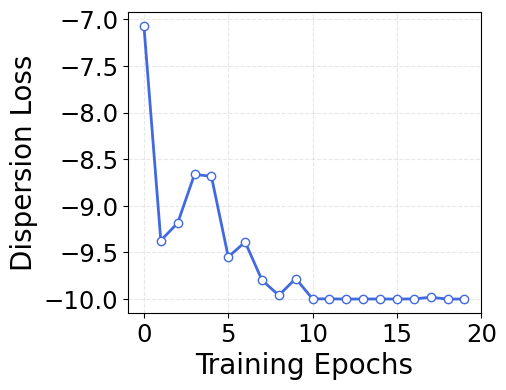

In [164]:
import matplotlib.pyplot as plt

# Create a figure with a specific size for publication
fig = plt.figure(figsize=(6, 4))

# Define custom colors for the line and markers
line_color = 'royalblue'
marker_face = 'white'
marker_edge = 'royalblue'

# Plot with custom colors, line width, and markers
plt.plot(tsdar.validation_dis, color=line_color, linewidth=2, marker='o',
         markersize=6, markerfacecolor=marker_face, markeredgecolor=marker_edge)

# Set the axis labels
plt.xlabel('Training Epochs', fontsize=20)
plt.ylabel('Dispersion Loss', fontsize=20)
#plt.ylim(0, 2.25)
#plt.yticks(np.arange(0, 2.1, 0.5))
plt.xticks(np.arange(0, 25, 5))

# Customize tick parameters for readability
plt.xticks(fontsize=17.5)
plt.yticks(fontsize=17.5)
plt.gca().set_box_aspect(0.85)

# Add a dashed grid to improve the readability of the plot
plt.grid(alpha=0.3, linestyle='--')

# Adjust the layout to ensure everything fits well
plt.tight_layout()

# Display the plot
plt.show()

## Estimate Metastable State Center Vectors & Compute Out-of-Distribution (OOD) Scores:
After training the **TS-DAR model**, we now:  

1. **Estimate metastable state center vectors** on the hypersphere.  
2. **Compute OOD scores** → Identifies rare conformations.  
3. **Extract hyperspherical embeddings** → Low-dimensional representation of data.  
4. **Compute OOD threshold** for detecting **transition state (TS).** structures.

### Key Concepts:
- **State Center Vectors**:
  - Represent metastable states in the learned hyperspherical latent space.
  - Are optimized via dispersion loss to be evenly spread out (maximally separated).  
- **OOD Scores**:
  - Measure of how "rare" a molecular conformation is relative to known metastable states.
- **OOD Threshold (`thres`)**: Helps detect transition states.
  - Two approaches:
      - **Theoretical** → Based on angular distances between state centers.  
      - **Empirical** → Based on the maximum OOD score in the dataset.
      - **Use the approach that gives you a smaller value**

In [165]:
# Initialize the TS-DAR Estimator to compute metastable state centers
tsdar_estimator = TSDAREstimator(tsdar_model)

# Compute the Out-of-Distribution (OOD) scores
ood_scores = tsdar_estimator.fit(data).ood_scores

# Extract the hyperspherical embeddings (transformed feature representation)
features = tsdar_model.transform(data,return_type='hypersphere_embs')

# Compute the state center vectors for metastable states on the hypersphere
state_centers = tsdar_estimator.fit(data).state_centers

# Compute the pairwise anglular distances between metastable state centers
sim_mat = np.arccos(state_centers.dot(state_centers.T))
np.fill_diagonal(sim_mat,val=np.pi)

# OOD Threshold Computation:

# Theoretical threshold (based on the angle between state centers)
# thres = -np.cos(sim_mat.min()/2)+1

# Empirical threshold (based on the maximum OOD score)
thres = np.max(np.concatenate(ood_scores))

# NOTE: use the smaller value for thres

/var/folders/9g/tn_8xgqj79527t9txzwlnh9c0000gn/T/ipykernel_73911/807288760.py:14: RuntimeWarning: invalid value encountered in arccos
  sim_mat = np.arccos(state_centers.dot(state_centers.T))


## Free Energy Landscape Colored by OOD Score:
This plot projects the **free energy landscape** of alanine dipeptide onto the two backbone torsion angles, **ϕ (phi) and ψ (psi)**. The dots represent sampled molecular conformations.

- **Color mapping**:
  - **Low OOD scores** (blue) → Metastable state conformations.
  - **High OOD scores** (red) → Rare or transition state conformations.

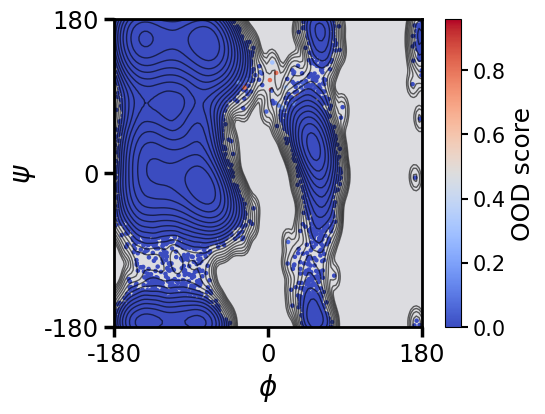

In [166]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Customize axis
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

# Ensure equal aspect ratio (important for angles)
ax.set_aspect('equal')

# Concatenate dihedral angles and OOD scores for easier handling
all_dihedral = np.concatenate(dihedral)
all_ood = np.concatenate(ood_scores)

# Main scatter plot (background) – small points colored by OOD scores
cb = ax.scatter(all_dihedral[:, 0], all_dihedral[:, 1],
                c=all_ood, cmap='coolwarm', s=5, alpha=1)

# Set colorbar range (thres is the OOD score cutoff)
cb.set_clim(0.0, thres)

# Add a colorbar with formatted ticks
ccc = fig.colorbar(cb)
ccc.ax.tick_params(labelsize=15, length=5, width=1.5)
ccc.set_label('OOD score',fontsize=18)

# Set axis limits (full range of dihedral angles)
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)

# Set axis labels with phi (ϕ) and psi (ψ) symbols
ax.set_xlabel(r'$\phi$', fontsize=20)
ax.set_ylabel(r'$\psi$', fontsize=20)

# Convert tick labels from radians to degrees
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([-180, 0, 180])
ax.set_yticks([-np.pi, 0, np.pi])
ax.set_yticklabels([-180, 0, 180])

# Add contour lines for free energy landscape
cs = ax.contour(X, Y, Z,
                colors='black',
                linewidths=1,
                levels=np.linspace(0, 12, 20),
                alpha=0.6,
                zorder=1, vmin=0, vmax=12)

# Customize tick labels and styling
ax.tick_params(axis="both", labelsize=17.5, direction='out', length=7.5, width=2.5)

# Set a background color for the axis
r, g, b = 0.1, 0.1, 0.2
ax.patch.set_facecolor((r, g, b, 0.15))


plt.show()

## Visualization of Hyperspherical Embeddings and Metastable State Centers:
This plot shows the **hyperspherical embeddings** (`features`) learned by the TS-DAR model, along with the **metastable state centers** (`state_centers`). Each dot represents a molecular conformation in the learned feature space.

### Key Features:
- **Color Mapping**: OOD scores differentiate between rare and metastable state conformations.
  - **Low OOD scores** (blue) → Metastable state conformations.
  - **High OOD scores** (red) → Rare or transition state conformations.
- **Dashed Black Line**: Shows **metastable state centers**.

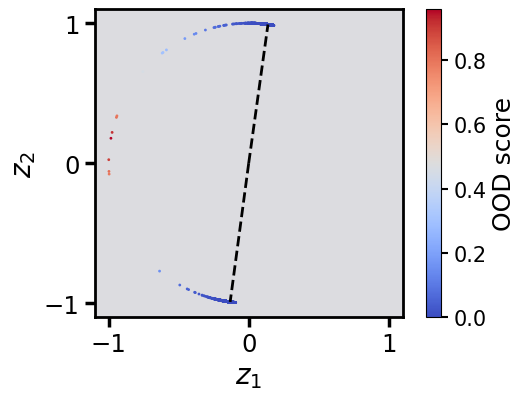

In [167]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.set_aspect('equal')

cb=ax.scatter(np.concatenate(features)[:,0],np.concatenate(features)[:,1],c=np.concatenate(ood_scores),cmap='coolwarm',s=1,alpha=1)
cb.set_clim(0.0,thres)

ccc = fig.colorbar(cb)
ccc.ax.tick_params(labelsize=15,length=5,width=1.5)
ccc.set_label('OOD score',fontsize=18)

ax.plot([0,state_centers[0,0]],[0,state_centers[0,1]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[1,0]],[0,state_centers[1,1]],linewidth=2,color='black',linestyle='--')

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)

ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])

# Set axis labels with phi (ϕ) and psi (ψ) symbols
ax.set_xlabel(r'$z_1$', fontsize=20)
ax.set_ylabel(r'$z_2$', fontsize=20)

ax.tick_params(axis="both",labelsize=17.5,direction='out',length=7.5,width=2.5)

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))

## Example: Training TS-DAR with 3 and 4 States
In the following section, we repeat the **same training procedure** but modify the number of **metastable states**. We provide **example training runs** for the **3-state and 4-state models** to illustrate how the TS-DAR framework can be adapted for different metastable state counts.  

### Important Note:
- The number of metastable states for your system should **not** be chosen arbitrarily. The correct approach is to **build a microstate Markov State Model (MSM)** and analyze the **Implied Timescales (ITS) plot**. The ITS plot shows the dominant relaxation timescales as a function of lag time, helping to confirm that the dynamics are Markovian and that the model is robust. The optimal number of metastable states can then be determined based on the system’s kinetics.
- For more detail, see: Wu, Y.; Cao, S.; Qiu, Y.; Huang, X. The Journal of Chemical Physics 2024, 160 (12). DOI: 10.1063/5.0189429

## 3-State Model:

In [168]:
set_random_seed(0)

val = int(len(dataset)*0.10)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset)-val, val]) # the way the dataset is split depends on the underlying pseudo-random number generator

loader_train = DataLoader(train_data, batch_size=1000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

lobe = TSDARLayer([30,30,30,30,10,2],n_states=3)
lobe = lobe.to(device=device)

tsdar = TSDAR(lobe = lobe, learning_rate = 1e-3, device = device, mode = 'regularize', beta=0.01 , feat_dim=2, n_states=3, pretrain=50)
tsdar_model = tsdar.fit(loader_train, n_epochs=60, validation_loader=loader_val).fetch_model()

In [173]:
# Initialize the TS-DAR Estimator to compute metastable state centers
tsdar_estimator = TSDAREstimator(tsdar_model)
# Compute Out-of-Distribution (OOD) scores
ood_scores = tsdar_estimator.fit(data).ood_scores
# Extract the hyperspherical embeddings (transformed feature representation)
features = tsdar_model.transform(data,return_type='hypersphere_embs')
# Compute the state center vectors for metastable states on the hypersphere
state_centers = tsdar_estimator.fit(data).state_centers
# Compute pairwise anglular distances between metastable state centers
sim_mat = np.arccos(state_centers.dot(state_centers.T))
np.fill_diagonal(sim_mat,val=np.pi)
# Theoretical threshold (based on minimum angle between state centers)
#thres = -np.cos(sim_mat.min()/2)+1
thres = np.max(np.concatenate(ood_scores))

/var/folders/9g/tn_8xgqj79527t9txzwlnh9c0000gn/T/ipykernel_73911/1772777546.py:10: RuntimeWarning: invalid value encountered in arccos
  sim_mat = np.arccos(state_centers.dot(state_centers.T))


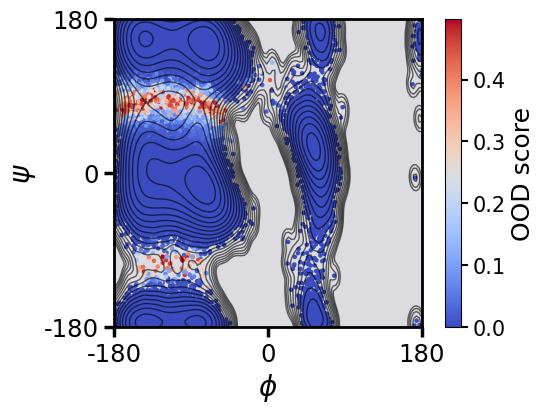

In [174]:
# TS-DAR model with 3 states successfully identified transition states (points with large OOD scores, shown in red)

fig,ax = plt.subplots(1,1,figsize=(6,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.set_aspect('equal')

cb=ax.scatter(np.concatenate(dihedral)[:,0],np.concatenate(dihedral)[:,1],c=np.concatenate(ood_scores),cmap='coolwarm',s=5,alpha=1)
cb.set_clim(0.0,thres)

ccc = fig.colorbar(cb)
ccc.ax.tick_params(labelsize=15,length=5,width=1.5)
ccc.set_label('OOD score',fontsize=18)

ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)

ax.set_xticks([-np.pi,0,np.pi],[-180,0,180])
ax.set_yticks([-np.pi,0,np.pi],[-180,0,180])

# Set axis labels with phi (ϕ) and psi (ψ) symbols
ax.set_xlabel(r'$\phi$', fontsize=20)
ax.set_ylabel(r'$\psi$', fontsize=20)

cs = ax.contour(X, Y, Z,
            colors='black',
            linewidths=1,
            levels=np.linspace(0, 12, 20), alpha=0.6,
            zorder=1, vmin=0, vmax=12)
ax.tick_params(axis="both",labelsize=17.5,direction='out',length=7.5,width=2.5)

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))

plt.show()

Text(0, 0.5, '$z_2$')

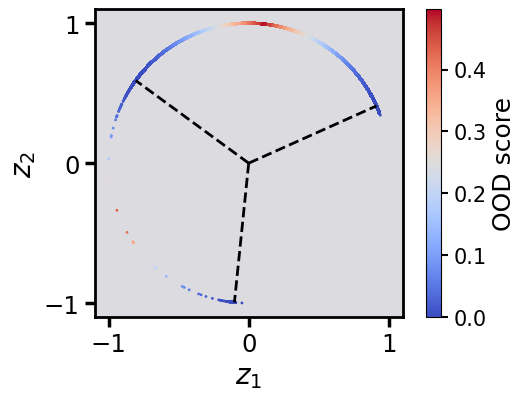

In [175]:
# Hyperspherical latent representations with OOD scores obtained from TS-DAR are shown. Dashed lines point to the centers of metastable states

fig,ax = plt.subplots(1,1,figsize=(6,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.set_aspect('equal')

cb=ax.scatter(np.concatenate(features)[:,0],np.concatenate(features)[:,1],c=np.concatenate(ood_scores),cmap='coolwarm',s=1,alpha=1)
cb.set_clim(0.0,thres)

ccc = fig.colorbar(cb)
ccc.ax.tick_params(labelsize=15,length=5,width=1.5)
ccc.set_label('OOD score',fontsize=18)

ax.plot([0,state_centers[0,0]],[0,state_centers[0,1]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[1,0]],[0,state_centers[1,1]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[2,0]],[0,state_centers[2,1]],linewidth=2,color='black',linestyle='--')

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)

ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])

ax.tick_params(axis="both",labelsize=17.5,direction='out',length=7.5,width=2.5)

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))

# Set axis labels with phi (ϕ) and psi (ψ) symbols
ax.set_xlabel(r'$z_1$', fontsize=20)
ax.set_ylabel(r'$z_2$', fontsize=20)

## 4-State Model:

In [176]:
set_random_seed(0)

val = int(len(dataset)*0.10)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset)-val, val])

loader_train = DataLoader(train_data, batch_size=1000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

lobe = TSDARLayer([30,30,30,30,10,3],n_states=4)
lobe = lobe.to(device=device)

tsdar = TSDAR(lobe = lobe, learning_rate = 1e-3, device = device, mode = 'regularize', beta=0.01, feat_dim=3, n_states=4, pretrain=50)
tsdar_model = tsdar.fit(loader_train, n_epochs=60, validation_loader=loader_val).fetch_model()

In [177]:
# Initialize the TS-DAR Estimator to compute metastable state centers
tsdar_estimator = TSDAREstimator(tsdar_model)
# Compute Out-of-Distribution (OOD) scores
ood_scores = tsdar_estimator.fit(data).ood_scores
# Extract the hyperspherical embeddings (transformed feature representation)
features = tsdar_model.transform(data,return_type='hypersphere_embs')
# Compute the state center vectors for metastable states on the hypersphere
state_centers = tsdar_estimator.fit(data).state_centers
# Compute pairwise anglular distances between metastable state centers
sim_mat = np.arccos(state_centers.dot(state_centers.T))
np.fill_diagonal(sim_mat,val=np.pi)
# Theoretical threshold (based on minimum angle between state centers)
#thres = -np.cos(sim_mat.min()/2)+1
thres = np.max(np.concatenate(ood_scores))

/var/folders/9g/tn_8xgqj79527t9txzwlnh9c0000gn/T/ipykernel_73911/1772777546.py:10: RuntimeWarning: invalid value encountered in arccos
  sim_mat = np.arccos(state_centers.dot(state_centers.T))


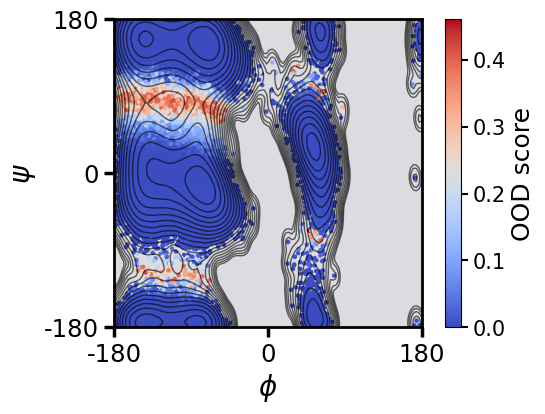

In [178]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.set_aspect('equal')

cb=ax.scatter(np.concatenate(dihedral)[:,0],np.concatenate(dihedral)[:,1],c=np.concatenate(ood_scores),cmap='coolwarm',s=5,alpha=1)
cb.set_clim(0.0,thres)

ccc = fig.colorbar(cb)
ccc.ax.tick_params(labelsize=15,length=5,width=1.5)
ccc.set_label('OOD score',fontsize=18)

ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)

# Set axis labels with phi (ϕ) and psi (ψ) symbols
ax.set_xlabel(r'$\phi$', fontsize=20)
ax.set_ylabel(r'$\psi$', fontsize=20)

ax.set_xticks([-np.pi,0,np.pi],[-180,0,180])
ax.set_yticks([-np.pi,0,np.pi],[-180,0,180])

cs = ax.contour(X, Y, Z,
            colors='black',
            linewidths=1,
            levels=np.linspace(0, 12, 20), alpha=0.6,
            zorder=1, vmin=0, vmax=12)
ax.tick_params(axis="both",labelsize=17.5,direction='out',length=7.5,width=2.5)

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))

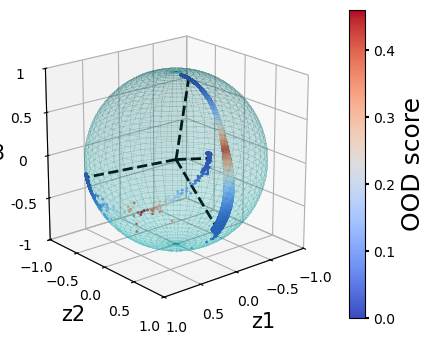

In [179]:
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)


plt.rcParams['figure.figsize'] = (6,4)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
   x, y, z,  rstride=2, cstride=2, color='c', alpha=0.1, linewidth=100,antialiased=False)

ax.plot([0,state_centers[0,0]],[0,state_centers[0,1]],[0,state_centers[0,2]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[1,0]],[0,state_centers[1,1]],[0,state_centers[1,2]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[2,0]],[0,state_centers[2,1]],[0,state_centers[2,2]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[3,0]],[0,state_centers[3,1]],[0,state_centers[3,2]],linewidth=2,color='black',linestyle='--')

cb = ax.scatter(np.concatenate(features)[:,0],np.concatenate(features)[:,1],np.concatenate(features)[:,2],c=ood_scores[:],s=1,alpha=1,cmap='coolwarm')
cb.set_clim(0.0,thres)

ccc = fig.colorbar(cb)
ccc.ax.tick_params(labelsize=10,length=3,width=1.5)
ccc.set_label('OOD score',fontsize=18)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_xticks([-1,-0.5,0,0.5,1])
ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_zticks([-1,-0.5,0,0.5,1],[-1,-0.5,0,0.5,1])
ax.set_aspect("equal")
ax.tick_params(axis="both",labelsize=10,direction='out',length=7.5,width=2.5)

ax.set_xlabel('z1',fontsize=15)
ax.set_ylabel('z2',fontsize=15)
ax.set_zlabel('z3',fontsize=15)

ax.view_init(elev=20, azim=50)